- 待调参数：【目标函数：突破线后30天内最大涨/跌幅超过20%的概率】
    - 寻找局部最值用的时间窗口
    - 合并各个**相邻峰**所用的标准差倍数
    - 合并**各条线**所用的方法（具体股价区间如2%近90天价差？还是峰附近股价的标准差？如果是标准差那么倍数和时间窗是多少？）
        - 注意第二条和第三条不是一件事！合并相邻峰是为了找important points，把横向相邻的点合并成一个；合并各条线则是已经找好points画好线之后，把纵向相邻的线合并成一条
- 模型流程：
    - 起床，画线
    - 开盘，如果突破，开始跟踪30天
    - 睡觉，要决定今天用过的线是否保留以后再用
- 评价指标：【突破定义为，当日收盘价高于线价3%】
    - #线坚持的时长（period）：之后过了多久股价没有触及该线
    - #触及次数（n）：该点之后股价触及该线的次数，无论是向上或向下【这里有个问题，就是被突破后，再看有没有触及还是否有意义】
    - 【现在只看这一个】疯狂程度（crazy）：突破后，股价最大上涨的幅度/波动性变动的程度
- 新的要求：
    - 股价突破线后是否回调（折腾）：突破后又回落的不好，找突破后不再回落到箱体内的边沿
    - 更注重“卧薪尝胆”的趋势股（股价几年趴窝，但超过某个点后突然**起爆**不再回头，找的就是这个点），而不是具有短期趋势的震荡股
    - 不能偷看未来数据！！

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override()
import mplfinance as mpf
my_style = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.family': 'SimHei'})
from pandas_datareader import data as pdr
from scipy import signal
import datetime
import warnings
import winsound
warnings.simplefilter("ignore")

In [13]:
def get_data(stock_code):
    data=pdr.get_data_yahoo(tickers=stock_code,
                            interval='1d',
                            start='2012-06-01',
                            end='2020-11-13')
    return data

In [15]:
data = get_data('600000.SS') # 找了一个震荡较大且趋势不明显的股票
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-06-01,6.13986,6.18182,6.11888,6.13986,3.936755,60634398
2012-06-04,6.09091,6.09091,6.00000,6.00699,3.851562,99196201
2012-06-05,6.02797,6.04196,5.97902,5.98601,3.838109,99623677
2012-06-06,6.00699,6.06993,5.97902,6.02797,3.865013,71383950
2012-06-07,6.06993,6.08392,5.96503,5.98601,3.838109,68677763
...,...,...,...,...,...,...
2020-11-06,9.37000,9.43000,9.33000,9.39000,9.390000,63919592
2020-11-09,9.42000,9.48000,9.39000,9.43000,9.430000,88937655
2020-11-10,9.47000,9.59000,9.44000,9.46000,9.460000,84217864


In [67]:
data1['Std'] = data1['Close'].rolling(5).std()
data1['Std'].fillna(data1['Std']['2018-01-08'], inplace=True)
data1

,Open,High,Low,Close,Adj Close,Volume,Std
Date,,,,,,,
2018-01-02,12.61,12.77,12.60,12.72,11.577287,31323053,0.024900
2018-01-03,12.73,12.80,12.66,12.66,11.522677,37839101,0.024900
2018-01-04,12.70,12.73,12.62,12.66,11.522677,27883804,0.024900
2018-01-05,12.67,12.71,12.62,12.69,11.549981,31026744,0.024900
2018-01-08,12.69,12.71,12.63,12.68,11.540881,31389887,0.024900
...,...,...,...,...,...,...,...
2020-11-06,9.37,9.43,9.33,9.39,9.390000,63919592,0.054498
2020-11-09,9.42,9.48,9.39,9.43,9.430000,88937655,0.049295
2020-11-10,9.47,9.59,9.44,9.46,9.460000,84217864,0.049295


### 寻找局部高点（低点）

**参数：**
- time_window: 时间窗，表示箱体向过去和未来延展的时间
- fuzzy: 模糊性，表示高于（或低于）附近交易日最高价（或最低价）的几倍5日滚动标准差才算有效高点（低点）
- combine: 合并系数，表示相邻几天内如果重复出现高点（或低点），则合并表示为第一次出现
    - *如果出现较长时间内高点（或低点）不断滚动出现的情况，说明这是一波上行（或下行）趋势，不适合箱体分析，正好不会被合并而选中*

In [131]:
time_window = 60
fuzzy = 1
combine = 5
local_high = []
local_low = []
for i in range(time_window, len(data1) - time_window + 1):
    d = data1.index[i]
    if data1.loc[d, 'High'] >= max([data1.loc[data1.index[j], 'High'] - fuzzy * data1.loc[data1.index[j], 'Std'] for j in range(i - time_window, i + time_window)]):
        local_high.append(i)
    if data1.loc[d, 'Low'] <= min([data1.loc[data1.index[j], 'Low'] + fuzzy * data1.loc[data1.index[j], 'Std'] for j in range(i - time_window, i + time_window)]):
        local_low.append(i)
combined_high = [local_high[0]]
combined_low = [local_low[0]]
for i in range(1, len(local_high)):
    if local_high[i] - local_high[i-1] >= combine:
        combined_high.append(local_high[i])
for i in range(1, len(local_low)):
    if local_low[i] - local_low[i-1] >= combine:
        combined_low.append(local_low[i])
local_high = [data1.index[i] for i in combined_high]
local_low = [data1.index[i] for i in combined_low]

local_high

[Timestamp('2018-11-02 00:00:00'),
 Timestamp('2019-03-04 00:00:00'),
 Timestamp('2019-06-20 00:00:00'),
 Timestamp('2019-10-14 00:00:00'),
 Timestamp('2019-11-05 00:00:00'),
 Timestamp('2020-07-06 00:00:00')]

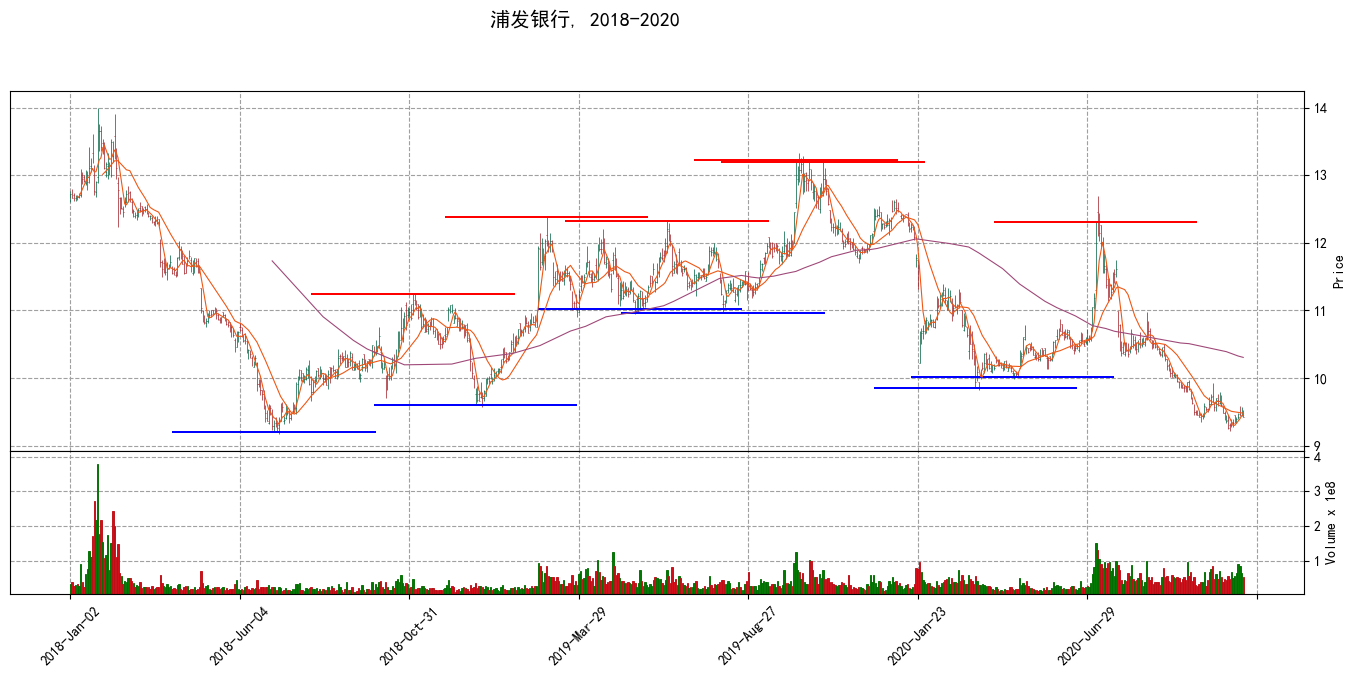

In [132]:
high_points = combined_high
low_points = combined_low
seq_of_points = [[(data1.index[i-time_window], data1.loc[data1.index[i],'High']), (data1.index[i+time_window],data.loc[data1.index[i],'High'])] for i in high_points] + [[(data1.index[i-time_window], data1.loc[data1.index[i], 'Low']), (data1.index[i+time_window],data.loc[data1.index[i],'Low'])] for i in low_points]
mpf.plot(data1, style=my_style, title='浦发银行, 2018-2020', mav=(5,20,120), figratio=(25,10), figscale=1.25, 
         alines=dict(alines=seq_of_points, colors=['r' for i in range(len(high_points))]+['b' for i in range(len(low_points))], linewidths=0.2),
         volume=True)

### 构造箱体上下沿 
**参数：**
- merge: 时间上相邻的两个局部高点（或低点），后者在超出前者几倍长期波动率时才会被保留，即被视为箱体变动
    - 为什么只判断相邻的边沿？因为不相邻的边沿即使相近，由于不属于同一个箱体，合并无意义
    - 为什么这里用长期波动率？因为是要合并跨期的边沿，为符合直观一般是与整个股票的上下浮动区间做比较
    *因为二者相差不大，假定总是用前者代替后者，省去了迭代的麻烦

In [166]:
merge = 0.2
merged_high = [combined_high[0]]
merged_low = [combined_low[0]]
for i in range(1, len(combined_high)):
    if abs(data1.loc[data1.index[combined_high[i]], 'High'] - data1.loc[data1.index[combined_high[i-1]], 'High']) >= merge * data1['Close'].std():
        merged_high.append(combined_high[i])
for i in range(1, len(combined_low)):
    if abs(data1.loc[data1.index[combined_low[i]], 'Low'] - data1.loc[data1.index[combined_low[i-1]], 'Low']) >= merge * data1['Close'].std():
        merged_low.append(combined_low[i])
local_high = [data1.index[i] for i in merged_high]
local_low = [data1.index[i] for i in merged_low]

local_high

[Timestamp('2018-11-02 00:00:00'),
 Timestamp('2019-03-04 00:00:00'),
 Timestamp('2019-10-14 00:00:00'),
 Timestamp('2020-07-06 00:00:00')]

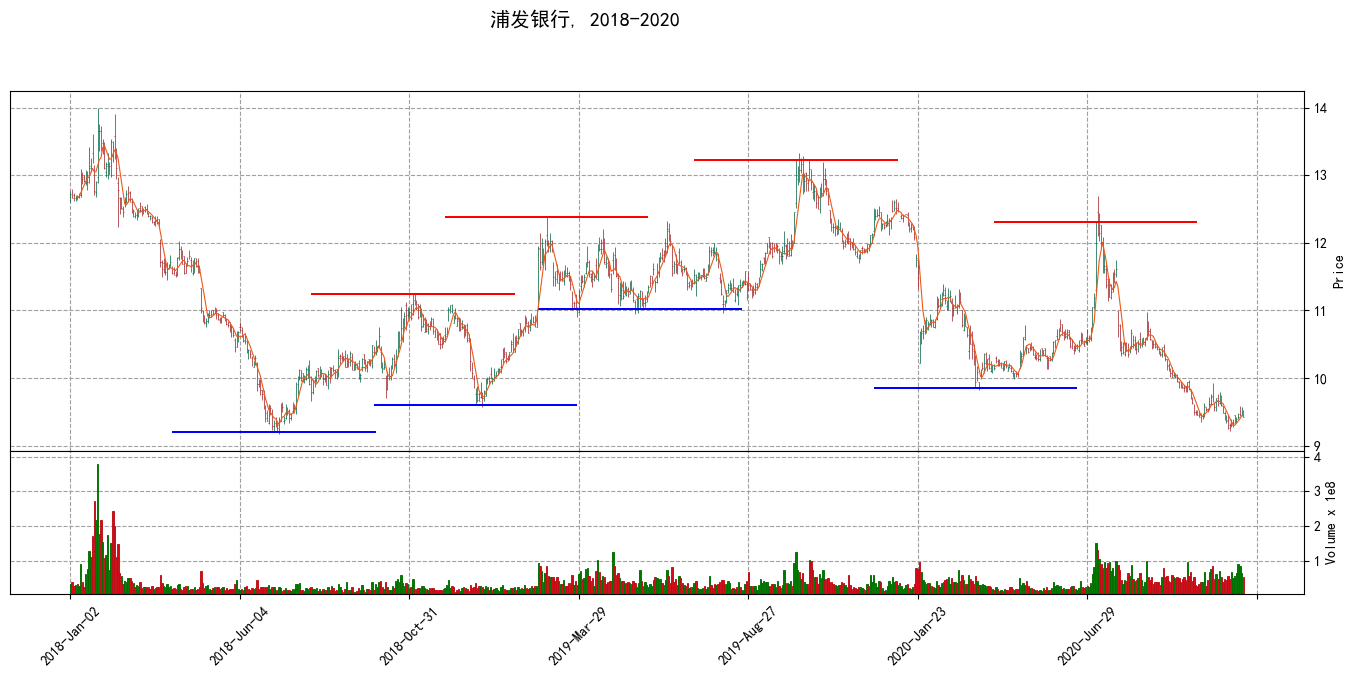

In [169]:
high_points = merged_high
low_points = merged_low
seq_of_points = [[(data1.index[i-time_window], data1.loc[data1.index[i],'High']), (data1.index[i+time_window],data.loc[data1.index[i],'High'])] for i in high_points] + [[(data1.index[i-time_window], data1.loc[data1.index[i], 'Low']), (data1.index[i+time_window],data.loc[data1.index[i],'Low'])] for i in low_points]
mpf.plot(data1, style=my_style, title='浦发银行, 2018-2020', mav=5, figratio=(25,10), figscale=1.25, 
         alines=dict(alines=seq_of_points, colors=['r' for i in range(len(high_points))]+['b' for i in range(len(low_points))], linewidths=0.2),
         volume=True)

### 尝试滚动箱体 

In [181]:
points = dict()
for i in local_high:
    points[i] = 'H'
for i in local_low:
    points[i] = 'L'
points = pd.Series(points).sort_index()
points

2018-07-03    L
2018-11-02    H
2018-12-25    L
2019-03-04    H
2019-05-28    L
2019-10-14    H
2020-03-19    L
2020-07-06    H
dtype: object

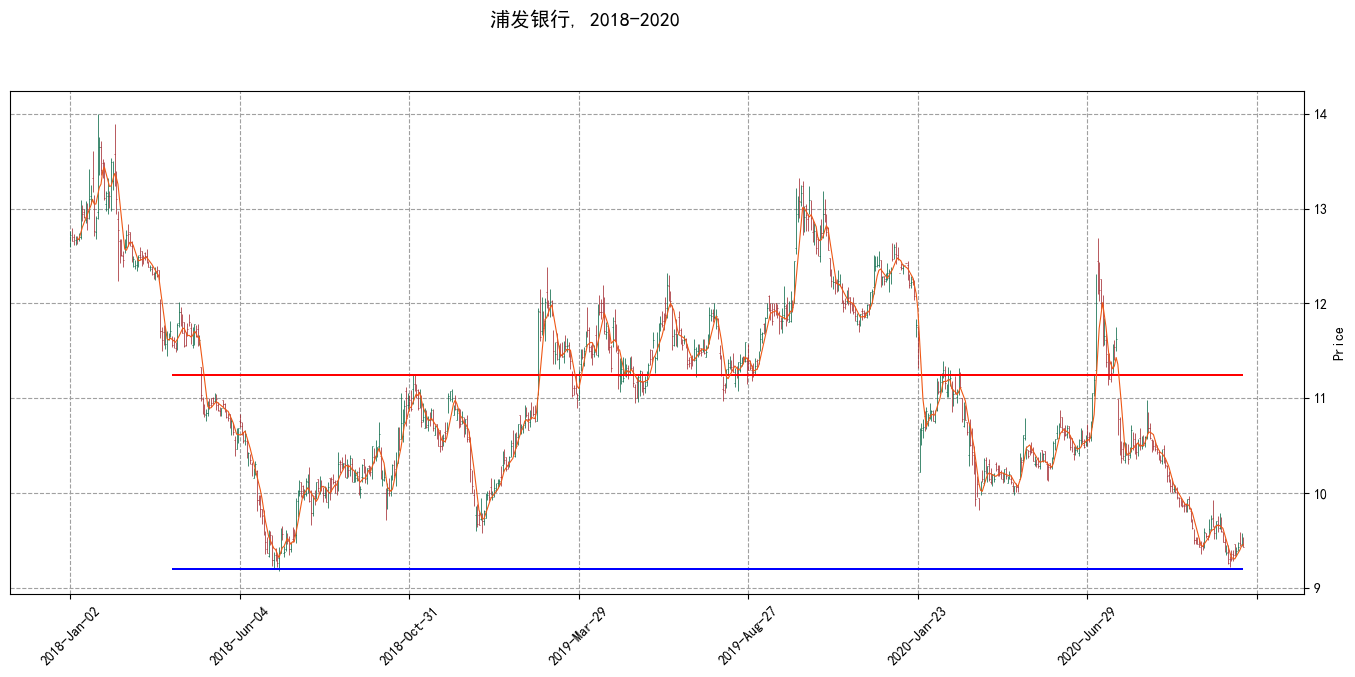

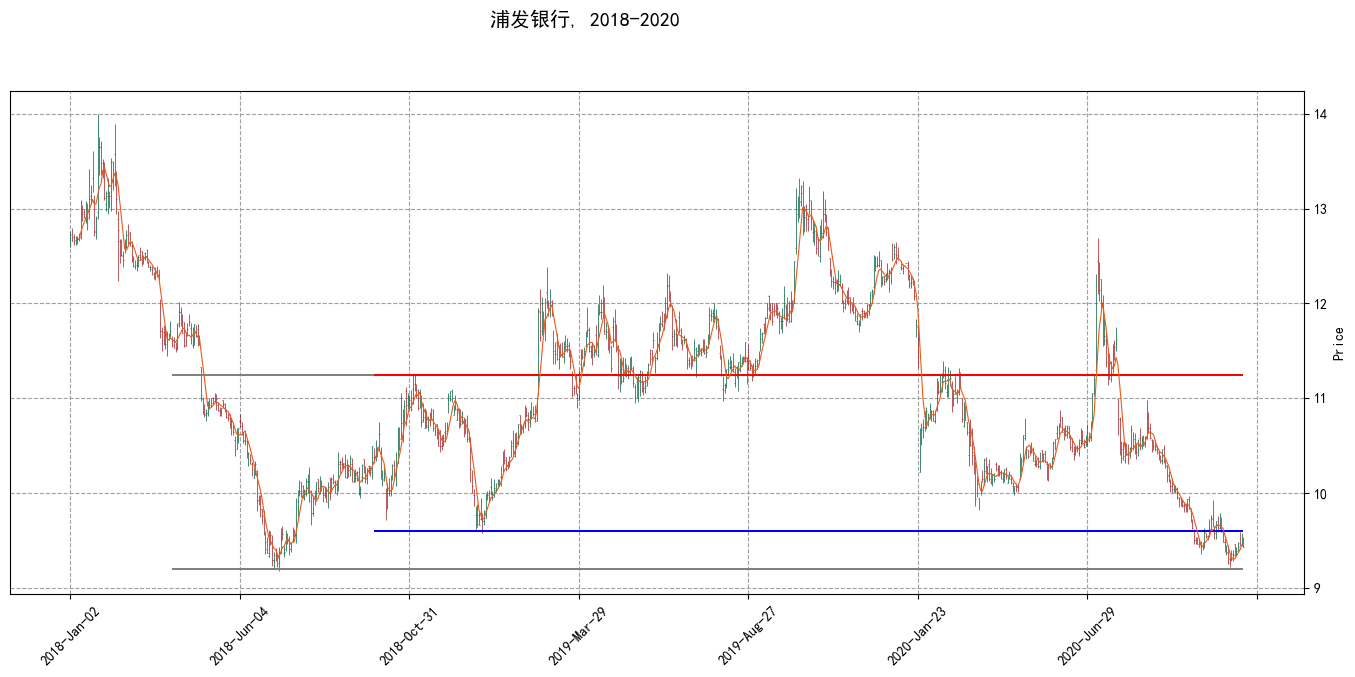

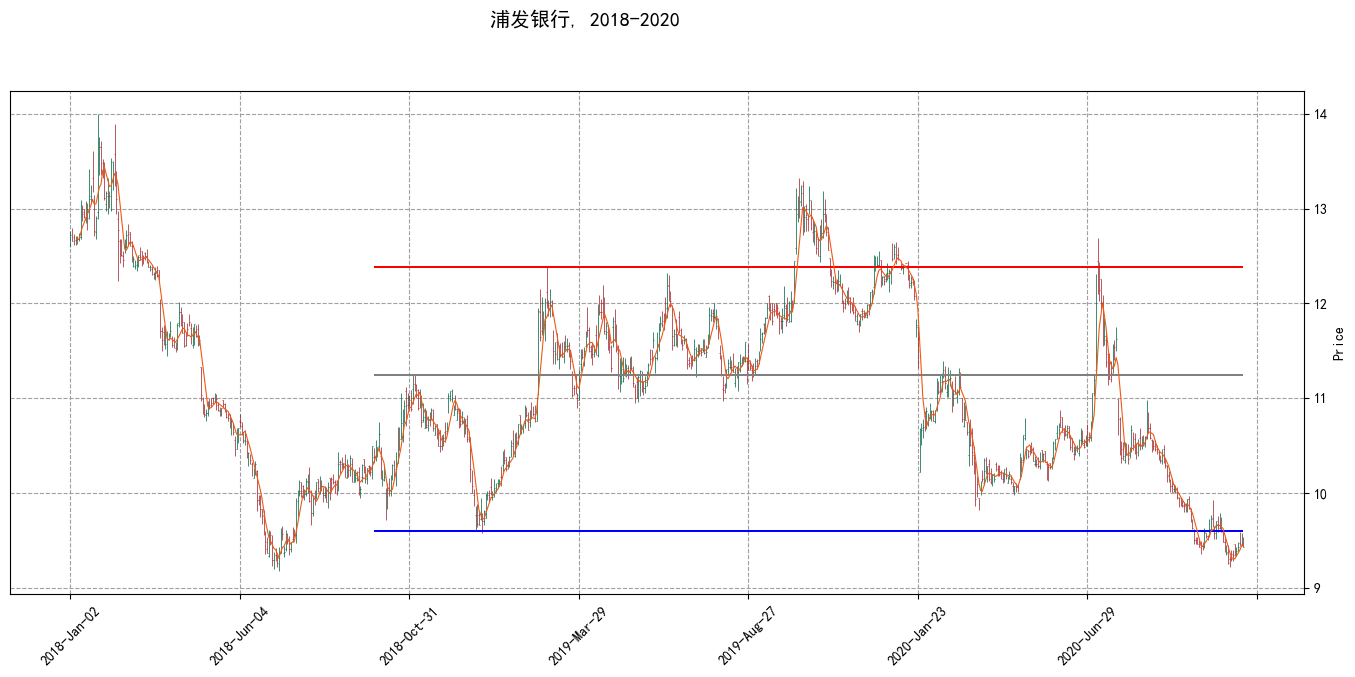

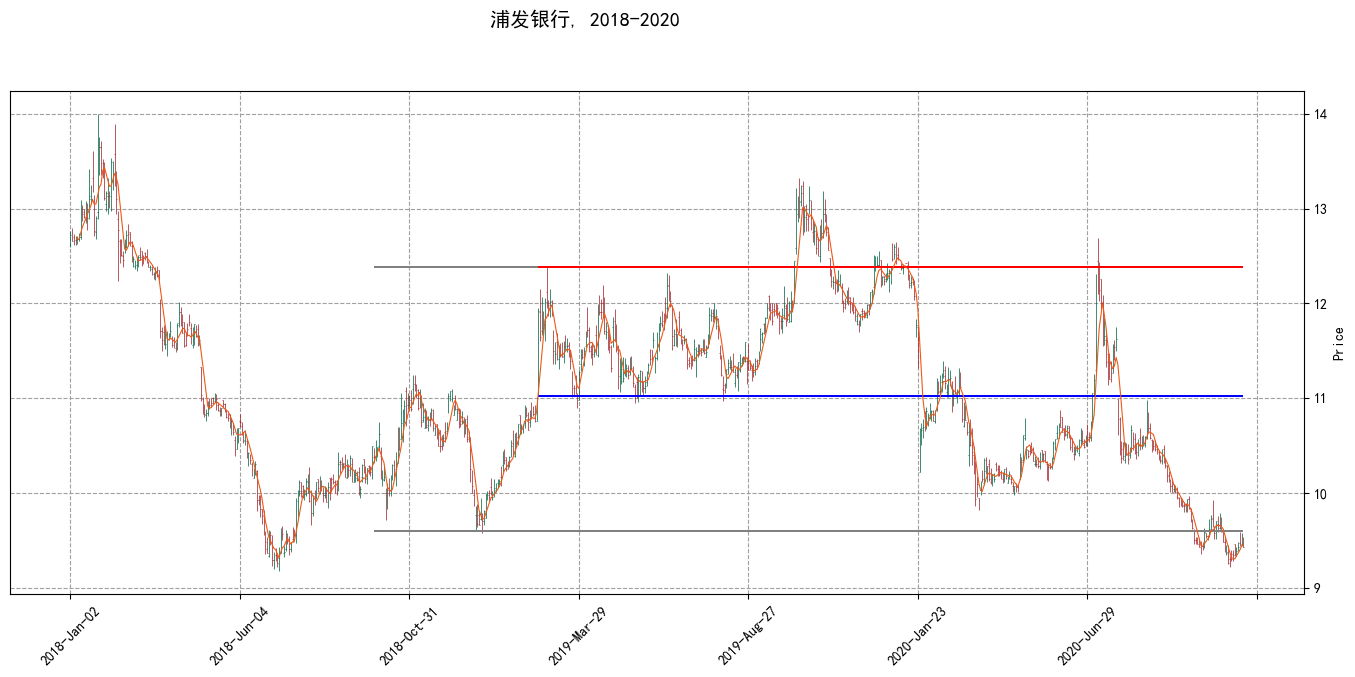

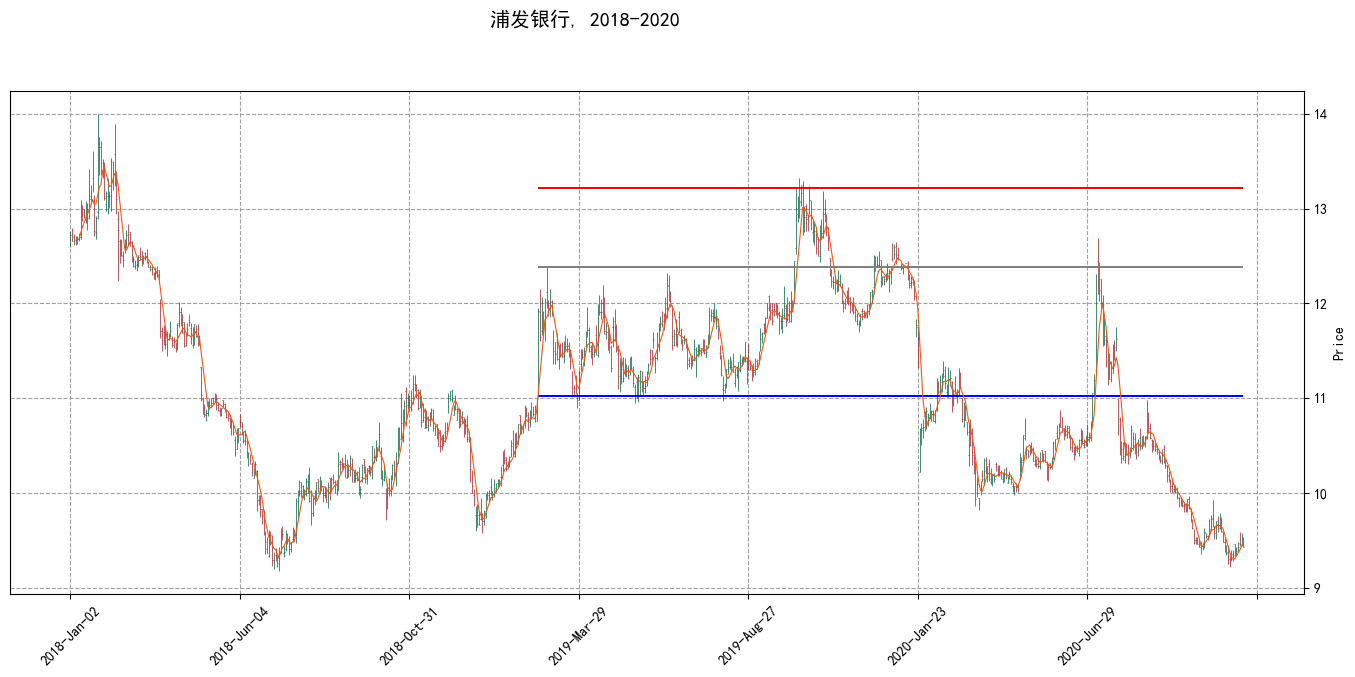

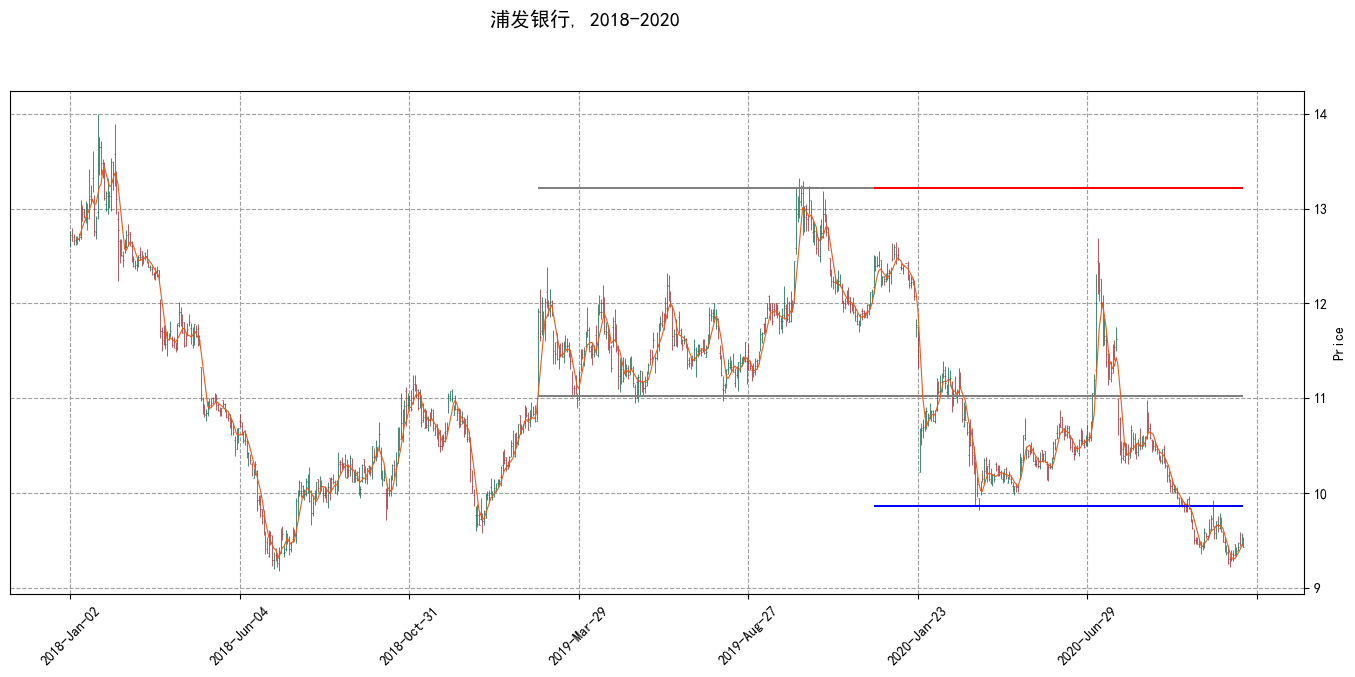

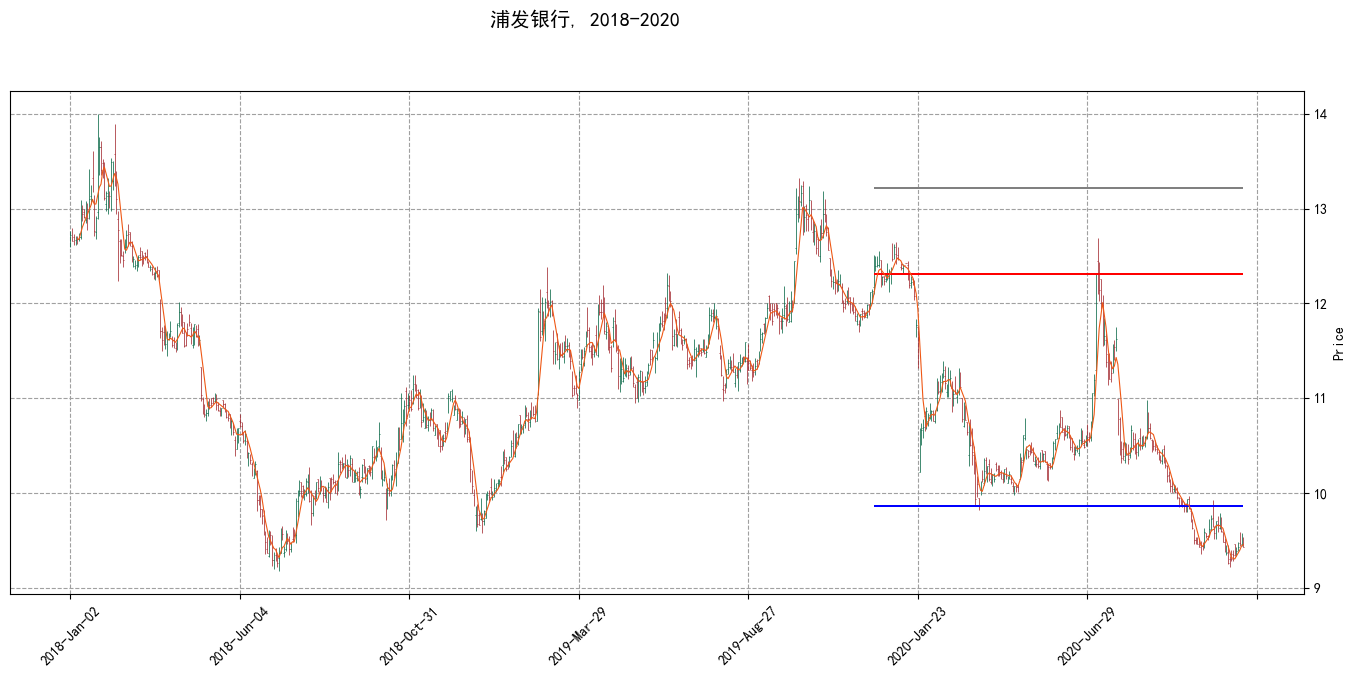

In [243]:
for i in range(1, len(points)):
    if i == 1:
        if points[i] != points[i-1]:
            if points[i] == 'H':
                high_point = merged_high[local_high.index(points.index[i])]
                low_point = merged_low[local_low.index(points.index[i-1])]
                seq_of_points = [[(data1.index[low_point-time_window], data1.loc[data1.index[high_point],'High']), (data1.index[-1],data.loc[data1.index[high_point],'High'])]] + [[(data1.index[low_point-time_window], data1.loc[data1.index[low_point],'Low']), (data1.index[-1],data.loc[data1.index[low_point],'Low'])]]
                mpf.plot(data1, style=my_style, title='浦发银行, 2018-2020', mav=5, figratio=(25,10), figscale=1.25, 
                         alines=dict(alines=seq_of_points, colors=['r','b'], linewidths=0.2),
                         volume=False)
            else:
                high_point = merged_high[local_high.index(points.index[i-1])]
                low_point = merged_low[local_low.index(points.index[i])]
                seq_of_points = [[(data1.index[high_point-time_window], data1.loc[data1.index[high_point],'High']), (data1.index[-1],data.loc[data1.index[high_point],'High'])]] + [[(data1.index[high_point-time_window], data1.loc[data1.index[low_point],'Low']), (data1.index[-1],data.loc[data1.index[low_point],'Low'])]]
                mpf.plot(data1, style=my_style, title='浦发银行, 2018-2020', mav=5, figratio=(25,10), figscale=1.25, 
                         alines=dict(alines=seq_of_points, colors=['r','b'], linewidths=0.2),
                         volume=False)
        else:
            pass
    else:
        if points[i] != points[i-1]:
            if points[i] == 'H':
                high_point = merged_high[local_high.index(points.index[i])]
                low_point = merged_low[local_low.index(points.index[i-1])]
                seq_of_points = seq_of_points + [[(data1.index[low_point-time_window], data1.loc[data1.index[high_point],'High']), (data1.index[-1],data.loc[data1.index[high_point],'High'])]] + [[(data1.index[low_point-time_window], data1.loc[data1.index[low_point],'Low']), (data1.index[-1],data.loc[data1.index[low_point],'Low'])]]
                mpf.plot(data1, style=my_style, title='浦发银行, 2018-2020', mav=5, figratio=(25,10), figscale=1.25, 
                         alines=dict(alines=seq_of_points, colors=['grey','grey','r','b'], linewidths=0.2),
                         volume=False)
                seq_of_points = seq_of_points[-2:]
            else:
                high_point = merged_high[local_high.index(points.index[i-1])]
                low_point = merged_low[local_low.index(points.index[i])]
                seq_of_points = seq_of_points + [[(data1.index[low_point-time_window], data1.loc[data1.index[high_point],'High']), (data1.index[-1],data.loc[data1.index[high_point],'High'])]] + [[(data1.index[low_point-time_window], data1.loc[data1.index[low_point],'Low']), (data1.index[-1],data.loc[data1.index[low_point],'Low'])]]
                mpf.plot(data1, style=my_style, title='浦发银行, 2018-2020', mav=5, figratio=(25,10), figscale=1.25, 
                         alines=dict(alines=seq_of_points, colors=['grey','grey','r','b'], linewidths=0.2),
                         volume=False)
                seq_of_points = seq_of_points[-2:]
        else:
            pass